In [104]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from functools import reduce

In [126]:
# Biggest wealth transfer occurs if poorest 51% take wealth of richest 49%,
# This is the system dynamics
def find_winners_and_losers(w, weights=None):
    if weights is None:
        n = len(w)
        median = n // 2
        w = sorted(w)
        return w[:median + 1], w[median + 1:]
    else:
        sorted_w, sorted_weights = zip(*sorted(zip(w, weights)))

        s = 0
        for i in range(len(sorted_weights)):
            new_s = s + sorted_weights[i]
            if s < 0.5 and new_s > 0.5:
                break_index = i + 1
            s = new_s
        return list(sorted_w[:break_index]), list(sorted_w[break_index:])

def voting_iteration(w0, use_weights=False):
    w = sorted(w0)

    if use_weights:
        s = sum(w)
        tau = [i/s for i in w]
        w_win, w_lose = find_winners_and_losers(w, tau)
    else:
        w_win, w_lose = find_winners_and_losers(w, None)

    # This is a redistribution policy, parametrize it
    # Another redistribution policy is where only one person
    # gets all the wealth of the losers
    wealth_limit = w_win[-1]
    n_win = len(w_win)
    n_lose = len(w_lose)
    s_lose = sum(w_lose)
    
    # Add uniformly
    to_add = s_lose/n_win
    
    # Count the number of winners having wealth equal to wealth_limit 
    n_swing = sum([i == wealth_limit for i in w_win])
    n_swings_so_far = 0

    for i in range(len(w0)):
        # If i is poor
        if w0[i] < wealth_limit:
            w0[i] += to_add

        # Else if i is rich
        elif w0[i] > wealth_limit:
            w0[i] = 0
        
        # Else, if he's on the margin
        else:
            # Count how many wealth_limit people we've seen so far
            n_swings_so_far += 1

            if n_swings_so_far > n_swing:
                w0[i] = 0
            else:
                w0[i] += to_add

    return w0, s_lose


def democracy_worst_case(w0, n_iterations=2):
    w = w0
    for i in range(n_iterations):
        w, transfer = voting_iteration(w)
        print("Iteration", i, "transfer", transfer, "wealth", w, sum(w))


def save_results(w0, n_iterations=50, use_weights=False):
    n = len(w0)
    results = np.zeros(shape=(n_iterations, n), dtype=float)
    transfers = np.zeros(n_iterations)
    
    w = w0
    for i in range(n_iterations):
        w, transfer = voting_iteration(w, use_weights)
        results[i] = w
        transfers[i] = transfer
    
    return results, transfers
    

w = [1, 2, 3, 4, 5, 40, 0.1, 0.1, 2.5, 5.5, 7, 2.3, 8, 10, 20, 25, 4, 4, 3]
r, t = save_results(w, 100, use_weights=False)
r2, t2 = save_results(w, 100, use_weights=True)

In [144]:
w = [1, 2, 3, 4]
r, t = save_results(w, 3, use_weights=False)

r

array([[2.33333333, 3.33333333, 4.33333333, 0.        ],
       [3.77777778, 4.77777778, 0.        , 1.44444444],
       [5.37037037, 0.        , 1.59259259, 3.03703704]])

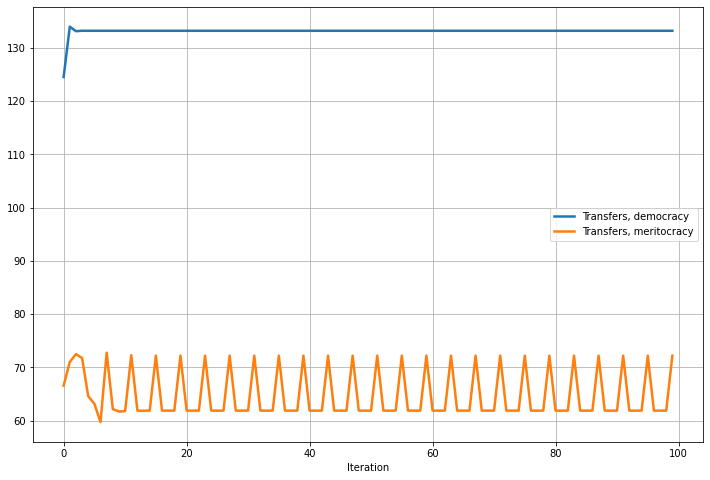

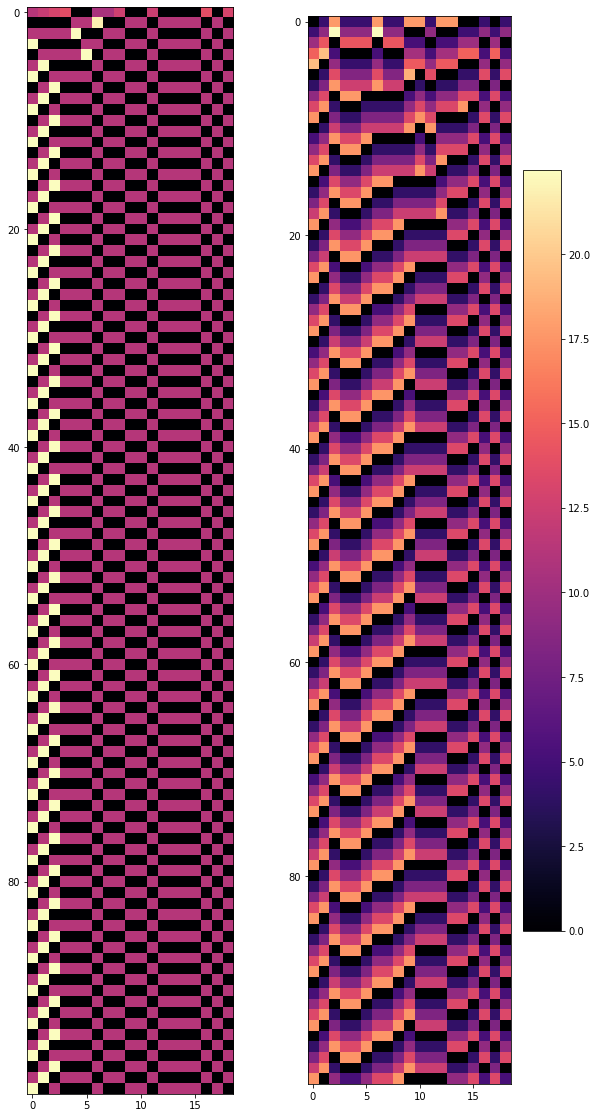

In [127]:
plt.figure(figsize=(12, 8), facecolor='white')
plt.plot(t, label='Transfers, democracy', linewidth=2.5)
plt.plot(t2, label='Transfers, meritocracy', linewidth=2.5)

plt.xlabel("Iteration")
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 20), facecolor='white')
plt.subplot(1, 2, 1)
plt.imshow(r, cmap='magma')
plt.subplot(1, 2, 2)
plt.imshow(r2, cmap='magma')
plt.colorbar()

In [139]:
r2[:4]

array([[ 0.        ,  4.43939394, 17.75757576,  4.43939394,  4.43939394,
         4.43939394, 17.75757576,  4.43939394,  4.43939394, 17.75757576,
        17.75757576,  4.43939394, 17.75757576, 17.75757576,  0.        ,
         0.        ,  4.43939394,  0.        ,  4.43939394],
       [ 4.73535354,  9.17474747, 22.49292929,  9.17474747,  9.17474747,
         9.17474747, 22.49292929,  9.17474747,  9.17474747,  0.        ,
         0.        ,  9.17474747,  0.        ,  0.        ,  4.73535354,
         4.73535354,  9.17474747,  4.73535354,  9.17474747],
       [ 9.91464646, 14.3540404 ,  0.        , 14.3540404 , 14.3540404 ,
        14.3540404 ,  0.        , 14.3540404 , 14.3540404 ,  5.17929293,
         5.17929293,  0.        ,  5.17929293,  5.17929293,  9.91464646,
         9.91464646,  0.        ,  9.91464646,  0.        ],
       [15.04108947, 19.48048341,  5.126443  ,  0.        ,  0.        ,
         0.        ,  5.126443  ,  0.        ,  0.        , 10.30573593,
        10.305

In [133]:
m1 = np.array(r[-1])
m2 = np.array(r2[-1])

def entropy(x):
    x = x + 1e-7
    p = x/x.sum()
    return -(p * np.log2(p)).sum()

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

def describe(x):
    print("mean", x.mean(), "std", x.std(), "entropy", entropy(x), "gini", gini(x))

print("Democracy equilibrium:")
describe(m1)

print("Meritocracy equilibrium:")
describe(m2)

# Meritocracy is more equal, has lower gini index

Democracy equilibrium:
mean 7.710526315789477 std 7.868222112378699 entropy 3.2776136131591804 gini 0.5167464047814231
Meritocracy equilibrium:
mean 7.71052631578948 std 5.877903153371317 entropy 3.685293247103358 gini 0.4292068143000631


In [51]:
def equilibrium_weight(w):
    n = len(w)
    median = n // 2
    n1 = len(w[:median + 1])
    c = sum(w)/len(w)
    _n = 0
    r = []
    i = 0
    print(n, n1, n//n1)
    for i in range(0, n//(n- n1)):
        print(i)
        r.extend([0 + i*c]*(n - n1))
    return r


m = [1, 2, 3, 4]
equilibrium_weight(m)
    

4 3 1
0
1
2
3


[0.0, 2.5, 5.0, 7.5]